# Optimization Methods

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

from opt_utils_v1a import load_params_and_grads, initialize_parameters, forward_propagation, backward_propagation
from opt_utils_v1a import compute_cost, predict, predict_dec, plot_decision_boundary, load_dataset
from copy import deepcopy
from testCases import *
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

2025-12-16 17:10:22.733488: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 17:10:22.808936: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765905022.841782    7240 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765905022.851327    7240 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-16 17:10:22.923415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Methods

### Batch Gradient Descent

In [8]:
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using one step of gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters to be updated:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients to update each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for l in range(1, L + 1):
        # (approx. 2 lines)
        # parameters["W" + str(l)] =  
        # parameters["b" + str(l)] = 
        # YOUR CODE STARTS HERE
        parameters['W' + str(l)] = parameters['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] = parameters['b' + str(l)] - learning_rate * grads['db' + str(l)]
        # YOUR CODE ENDS HERE
    return parameters

In [9]:
parameters, grads, learning_rate = update_parameters_with_gd_test_case()
learning_rate = 0.01
parameters = update_parameters_with_gd(parameters, grads, learning_rate)

print("W1 =\n" + str(parameters["W1"]))
print("b1 =\n" + str(parameters["b1"]))
print("W2 =\n" + str(parameters["W2"]))
print("b2 =\n" + str(parameters["b2"]))

update_parameters_with_gd_test(update_parameters_with_gd)

W1 =
[[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 =
[[ 1.74604067]
 [-0.75184921]]
W2 =
[[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 =
[[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]
All test passed


### Mini-batch

In [11]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    
    return mini_batches

In [13]:
np.random.seed(1)
mini_batch_size = 64
nx = 12288
m = 148
X = np.array([x for x in range(nx * m)]).reshape((m, nx)).T
Y = np.random.randn(1, m) < 0.5

mini_batches = random_mini_batches(X, Y, mini_batch_size)
n_batches = len(mini_batches)

assert n_batches == math.ceil(m / mini_batch_size), f"Wrong number of mini batches. {n_batches} != {math.ceil(m / mini_batch_size)}"
for k in range(n_batches - 1):
    assert mini_batches[k][0].shape == (nx, mini_batch_size), f"Wrong shape in {k} mini batch for X"
    assert mini_batches[k][1].shape == (1, mini_batch_size), f"Wrong shape in {k} mini batch for Y"
    assert np.sum(np.sum(mini_batches[k][0] - mini_batches[k][0][0], axis=0)) == ((nx * (nx - 1) / 2 ) * mini_batch_size), "Wrong values. It happens if the order of X rows(features) changes"
if ( m % mini_batch_size > 0):
    assert mini_batches[n_batches - 1][0].shape == (nx, m % mini_batch_size), f"Wrong shape in the last minibatch. {mini_batches[n_batches - 1][0].shape} != {(nx, m % mini_batch_size)}"

assert np.allclose(mini_batches[0][0][0][0:3], [294912,  86016, 454656]), "Wrong values. Check the indexes used to form the mini batches"
assert np.allclose(mini_batches[-1][0][-1][0:3], [1425407, 1769471, 897023]), "Wrong values. Check the indexes used to form the mini batches"

print("\033[92mAll test passed!")

t_X, t_Y, mini_batch_size = random_mini_batches_test_case()
mini_batches = random_mini_batches(t_X, t_Y, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

random_mini_batches_test(random_mini_batches)

All test passed!
shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]
 All tests passed.


### Momentum

In [16]:
def initialize_velocity(parameters):
    """
    Initializes the velocity as a python dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- python dictionary containing the current velocity.
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(1, L + 1):
        # v["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        # v["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)

        # Better
        v["dW" + str(l)] = np.zeros_like(parameters['W' + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters['b' + str(l)])
        
        
    return v

In [17]:
parameters = initialize_velocity_test_case()

v = initialize_velocity(parameters)
print("v[\"dW1\"] =\n" + str(v["dW1"]))
print("v[\"db1\"] =\n" + str(v["db1"]))
print("v[\"dW2\"] =\n" + str(v["dW2"]))
print("v[\"db2\"] =\n" + str(v["db2"]))

initialize_velocity_test(initialize_velocity)

v["dW1"] =
[[0. 0.]
 [0. 0.]
 [0. 0.]]
v["db1"] =
[[0.]
 [0.]]
v["dW2"] =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] =
[[0.]
 [0.]
 [0.]]
 All tests passed.


In [20]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- python dictionary containing your updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(1, L + 1):
        
        # (approx. 4 lines)
        # compute velocities
        v["dW" + str(l)] = beta * v['dW' + str(l)] + (1 - beta) * grads['dW' + str(l)]
        v["db" + str(l)] = beta * v['db' + str(l)] + (1 - beta) * grads['db' + str(l)]
        # update parameters
        parameters["W" + str(l)] = parameters['W' + str(l)] - learning_rate * v['dW' + str(l)]
        parameters["b" + str(l)] = parameters['b' + str(l)] - learning_rate * v['db' + str(l)]
        # YOUR CODE STARTS HERE
        
        # YOUR CODE ENDS HERE
        
    return parameters, v

In [21]:
parameters, grads, v = update_parameters_with_momentum_test_case()

parameters, v = update_parameters_with_momentum(parameters, grads, v, beta = 0.9, learning_rate = 0.01)
print("W1 = \n" + str(parameters["W1"]))
print("b1 = \n" + str(parameters["b1"]))
print("W2 = \n" + str(parameters["W2"]))
print("b2 = \n" + str(parameters["b2"]))
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = v" + str(v["db2"]))

update_parameters_with_momentum_test(update_parameters_with_momentum)

W1 = 
[[ 1.62544598 -0.61290114 -0.52907334]
 [-1.07347112  0.86450677 -2.30085497]]
b1 = 
[[ 1.74493465]
 [-0.76027113]]
W2 = 
[[ 0.31930698 -0.24990073  1.4627996 ]
 [-2.05974396 -0.32173003 -0.38320915]
 [ 1.13444069 -1.0998786  -0.1713109 ]]
b2 = 
[[-0.87809283]
 [ 0.04055394]
 [ 0.58207317]]
v["dW1"] = 
[[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = 
[[-0.01228902]
 [-0.09357694]]
v["dW2"] = 
[[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = v[[0.02344157]
 [0.16598022]
 [0.07420442]]
 All tests passed.


### ADAM

In [23]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros_like(parameters['W' + str(l)])
        v["db" + str(l)] = np.zeros_like(parameters['b' + str(l)])
        s["dW" + str(l)] = np.zeros_like(parameters['W' + str(l)])
        s["db" + str(l)] = np.zeros_like(parameters['b' + str(l)])
    
    return v, s

In [24]:
parameters = initialize_adam_test_case()

v, s = initialize_adam(parameters)
print("v[\"dW1\"] = \n" + str(v["dW1"]))
print("v[\"db1\"] = \n" + str(v["db1"]))
print("v[\"dW2\"] = \n" + str(v["dW2"]))
print("v[\"db2\"] = \n" + str(v["db2"]))
print("s[\"dW1\"] = \n" + str(s["dW1"]))
print("s[\"db1\"] = \n" + str(s["db1"]))
print("s[\"dW2\"] = \n" + str(s["dW2"]))
print("s[\"db2\"] = \n" + str(s["db2"]))

initialize_adam_test(initialize_adam)

v["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
v["db1"] = 
[[0.]
 [0.]]
v["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
v["db2"] = 
[[0.]
 [0.]
 [0.]]
s["dW1"] = 
[[0. 0. 0.]
 [0. 0. 0.]]
s["db1"] = 
[[0.]
 [0.]]
s["dW2"] = 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
s["db2"] = 
[[0.]
 [0.]
 [0.]]
 All tests passed.


In [27]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        v_corrected["dW" + str(l)] = v['dW' + str(l)] / (1 - beta1**t)
        v_corrected["db" + str(l)] = v['db' + str(l)] / (1 - beta1**t)

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        s["dW" + str(l)] = beta2 * s['dW' + str(l)] + (1 - beta2) * grads['dW' + str(l)]**2
        s["db" + str(l)] = beta2 * s['db' + str(l)] + (1 - beta2) * grads['db' + str(l)]**2

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        s_corrected["dW" + str(l)] = s['dW' + str(l)] / (1 - beta2**t)
        s_corrected["db" + str(l)] = s['db' + str(l)] / (1 - beta2**t)

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected['dW' + str(l)] / (np.sqrt(s_corrected['dW' + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected['db' + str(l)] / (np.sqrt(s_corrected['db' + str(l)]) + epsilon)

    return parameters, v, s, v_corrected, s_corrected

In [28]:
parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon = update_parameters_with_adam_test_case()

parameters, v, s, vc, sc  = update_parameters_with_adam(parametersi, grads, vi, si, t, learning_rate, beta1, beta2, epsilon)
print(f"W1 = \n{parameters['W1']}")
print(f"W2 = \n{parameters['W2']}")
print(f"b1 = \n{parameters['b1']}")
print(f"b2 = \n{parameters['b2']}")

update_parameters_with_adam_test(update_parameters_with_adam)

W1 = 
[[ 1.63942428 -0.6268425  -0.54320974]
 [-1.08782943  0.85036983 -2.2865723 ]]
W2 = 
[[ 0.33356139 -0.26425199  1.47707772]
 [-2.04538458 -0.30744933 -0.36903141]
 [ 1.14873036 -1.09256871 -0.15734651]]
b1 = 
[[ 1.75854357]
 [-0.74616067]]
b2 = 
[[-0.89228024]
 [ 0.02707193]
 [ 0.56782561]]
All test passed


## Optimized model example 

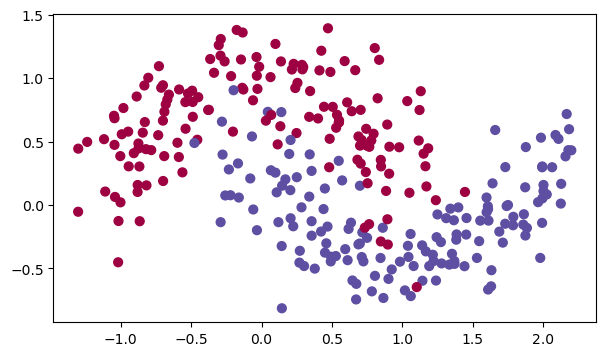

In [29]:
train_X, train_Y = load_dataset()

In [30]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    optimizer -- the optimizer to be passed, gradient descent, momentum or adam
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### Mini-batch gradient descent

Cost after epoch 0: 0.702405
Cost after epoch 1000: 0.668101
Cost after epoch 2000: 0.635288
Cost after epoch 3000: 0.600491
Cost after epoch 4000: 0.573367


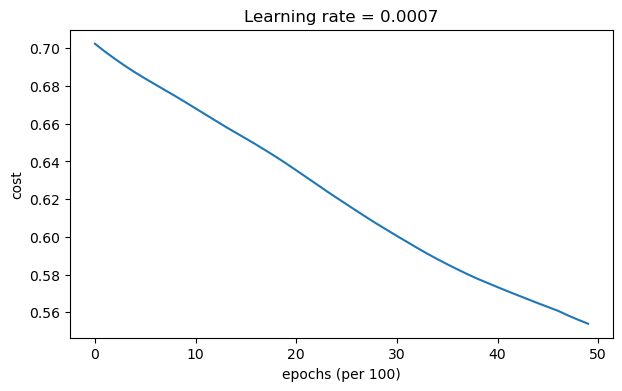

Accuracy: 0.7166666666666667


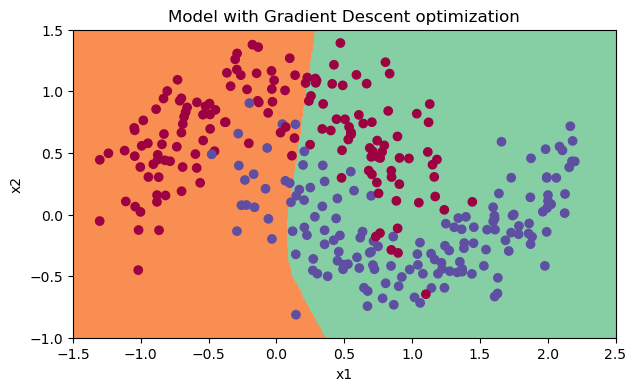

In [32]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-batch gradient descent with Momentum

Cost after epoch 0: 0.702413
Cost after epoch 1000: 0.668167
Cost after epoch 2000: 0.635388
Cost after epoch 3000: 0.600591
Cost after epoch 4000: 0.573444


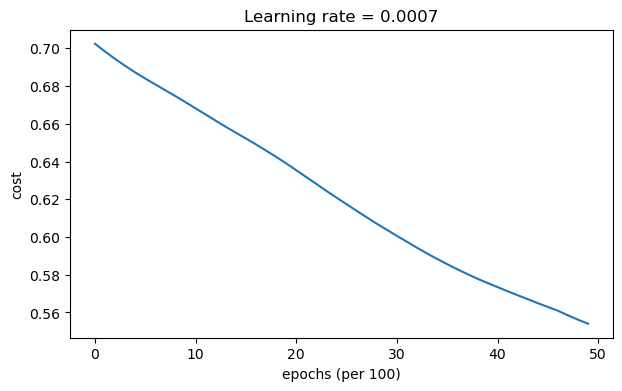

Accuracy: 0.7166666666666667


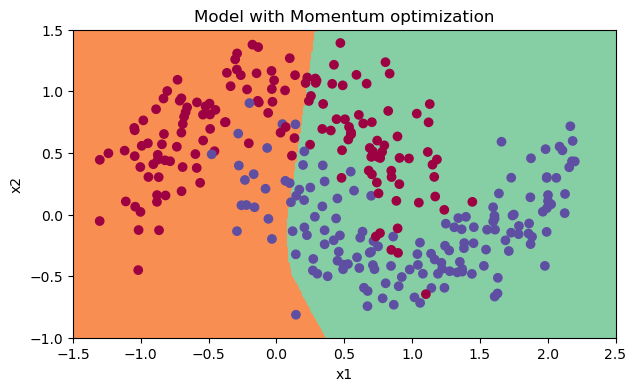

In [33]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, beta = 0.9, optimizer = "momentum")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Mini-batch with Adam

Cost after epoch 0: 0.702166
Cost after epoch 1000: 0.167845
Cost after epoch 2000: 0.141316
Cost after epoch 3000: 0.138788
Cost after epoch 4000: 0.136066


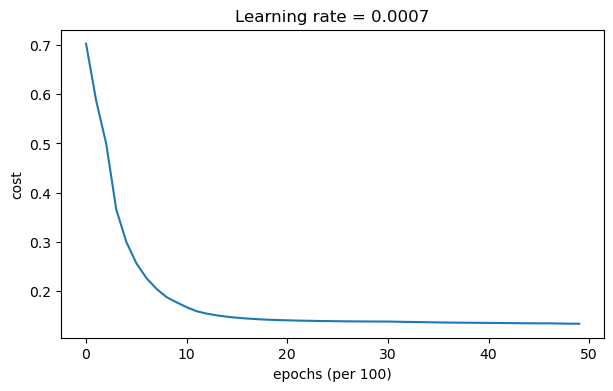

Accuracy: 0.9433333333333334


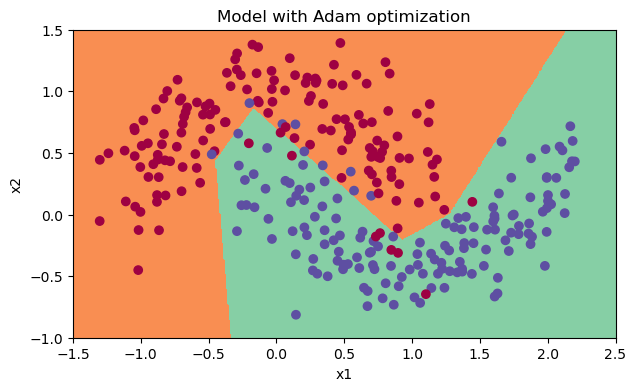

In [34]:
# train 3-layer model
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam")

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Learning rate decay and Scheduling

In [35]:
def model(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9,
          beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 5000, print_cost = True, decay=None, decay_rate=1):
    """
    3-layer neural network model which can be run in different optimizer modes.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """

    L = len(layers_dims)             # number of layers in the neural networks
    costs = []                       # to keep track of the cost
    t = 0                            # initializing the counter required for Adam update
    seed = 10                        # For grading purposes, so that your "random" minibatches are the same as ours
    m = X.shape[1]                   # number of training examples
    lr_rates = []
    learning_rate0 = learning_rate   # the original learning rate
    
    # Initialize parameters
    parameters = initialize_parameters(layers_dims)

    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # Optimization loop
    for i in range(num_epochs):
        
        # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        cost_total = 0
        
        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            a3, caches = forward_propagation(minibatch_X, parameters)

            # Compute cost and add to the cost total
            cost_total += compute_cost(a3, minibatch_Y)

            # Backward propagation
            grads = backward_propagation(minibatch_X, minibatch_Y, caches)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        cost_avg = cost_total / m
        if decay:
            learning_rate = decay(learning_rate0, i, decay_rate)
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
            if decay:
                print("learning rate after epoch %i: %f"%(i, learning_rate))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

In [38]:
def update_lr(learning_rate0, epoch_num, decay_rate):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer
    decay_rate -- Decay rate. Scalar

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    
    learning_rate = learning_rate0 / (1 + epoch_num * decay_rate)
    
    return learning_rate

In [39]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)
epoch_num = 2
decay_rate = 1
learning_rate_2 = update_lr(learning_rate, epoch_num, decay_rate)

print("Updated learning rate: ", learning_rate_2)

update_lr_test(update_lr)

Original learning rate:  0.5
Updated learning rate:  0.16666666666666666
All test passed


Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.661884
learning rate after epoch 1000: 0.000100
Cost after epoch 2000: 0.658620
learning rate after epoch 2000: 0.000050
Cost after epoch 3000: 0.656765
learning rate after epoch 3000: 0.000033
Cost after epoch 4000: 0.655486
learning rate after epoch 4000: 0.000025


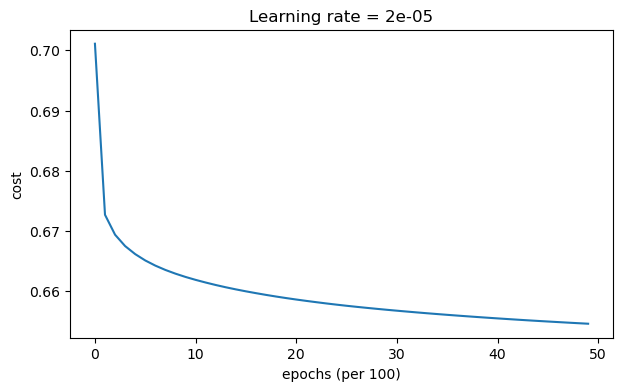

Accuracy: 0.6533333333333333


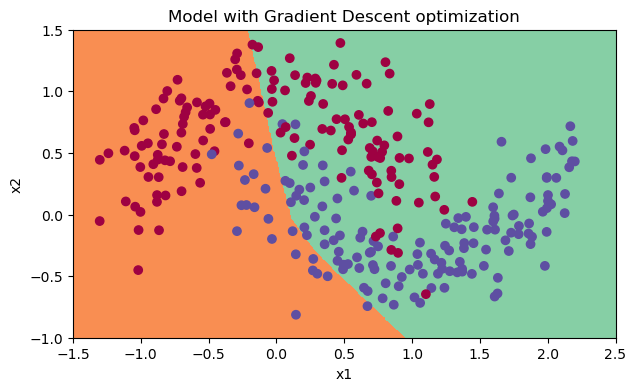

In [40]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=update_lr)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [41]:
def schedule_lr_decay(learning_rate0, epoch_num, decay_rate, time_interval=1000):
    """
    Calculates updated the learning rate using exponential weight decay.
    
    Arguments:
    learning_rate0 -- Original learning rate. Scalar
    epoch_num -- Epoch number. Integer.
    decay_rate -- Decay rate. Scalar.
    time_interval -- Number of epochs where you update the learning rate.

    Returns:
    learning_rate -- Updated learning rate. Scalar 
    """
    
    learning_rate = learning_rate0 / (1 + decay_rate * (np.floor(epoch_num / time_interval)))

    return learning_rate

In [42]:
learning_rate = 0.5
print("Original learning rate: ", learning_rate)

epoch_num_1 = 10
epoch_num_2 = 100
decay_rate = 0.3
time_interval = 100
learning_rate_1 = schedule_lr_decay(learning_rate, epoch_num_1, decay_rate, time_interval)
learning_rate_2 = schedule_lr_decay(learning_rate, epoch_num_2, decay_rate, time_interval)
print("Updated learning rate after {} epochs: ".format(epoch_num_1), learning_rate_1)
print("Updated learning rate after {} epochs: ".format(epoch_num_2), learning_rate_2)

schedule_lr_decay_test(schedule_lr_decay)

Original learning rate:  0.5
Updated learning rate after 10 epochs:  0.5
Updated learning rate after 100 epochs:  0.3846153846153846
All test passed


### Gradient Descent with Learning Rate Decay

Cost after epoch 0: 0.701091
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.127161
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.120304
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.117033
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.117512
learning rate after epoch 4000: 0.020000


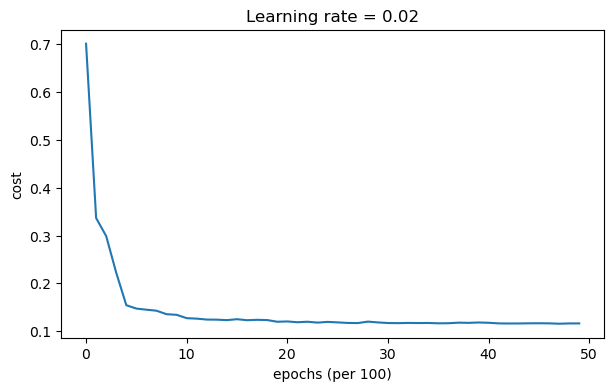

Accuracy: 0.9433333333333334


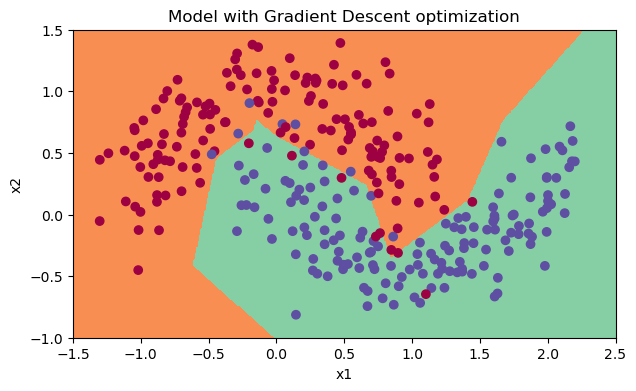

In [43]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Gradient Descent with Momentum and Learning Rate Decay

Cost after epoch 0: 0.702226
learning rate after epoch 0: 0.100000
Cost after epoch 1000: 0.128974
learning rate after epoch 1000: 0.050000
Cost after epoch 2000: 0.125965
learning rate after epoch 2000: 0.033333
Cost after epoch 3000: 0.123375
learning rate after epoch 3000: 0.025000
Cost after epoch 4000: 0.123218
learning rate after epoch 4000: 0.020000


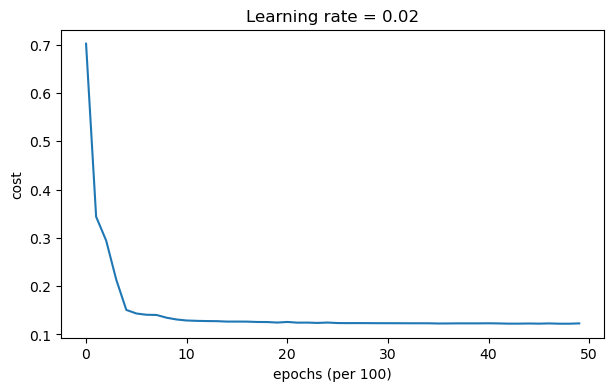

Accuracy: 0.9533333333333334


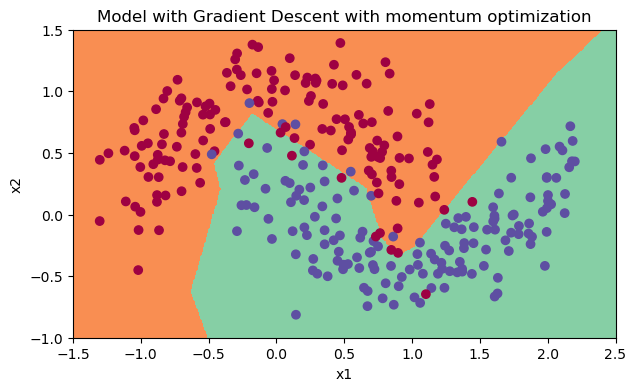

In [44]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "momentum", learning_rate = 0.1, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent with momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

### Adam with Learning Rate Decay

Cost after epoch 0: 0.699346
learning rate after epoch 0: 0.010000
Cost after epoch 1000: 0.130074
learning rate after epoch 1000: 0.005000
Cost after epoch 2000: 0.129826
learning rate after epoch 2000: 0.003333
Cost after epoch 3000: 0.129282
learning rate after epoch 3000: 0.002500
Cost after epoch 4000: 0.128361
learning rate after epoch 4000: 0.002000


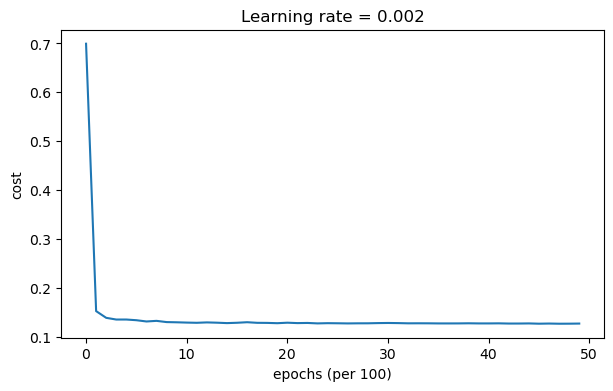

Accuracy: 0.94


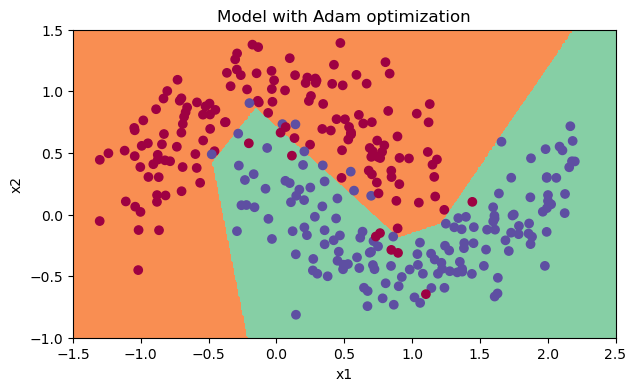

In [45]:
layers_dims = [train_X.shape[0], 5, 2, 1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "adam", learning_rate = 0.01, num_epochs=5000, decay=schedule_lr_decay)

# Predict
predictions = predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)